In [ ]:
#import the required libraries
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/Karen/CNN_assignment.zip (Unzipped Files)/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/Karen/CNN_assignment.zip (Unzipped Files)/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count

image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [ ]:
batch_size = 32
img_height = 180
img_width = 180

# Data Visualization

In [ ]:
#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

Found 6739 files belonging to 9 classes.


In [ ]:
#all the classes of Skin Cancer
class_names = image_dataset.class_names
class_names


['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [ ]:
#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

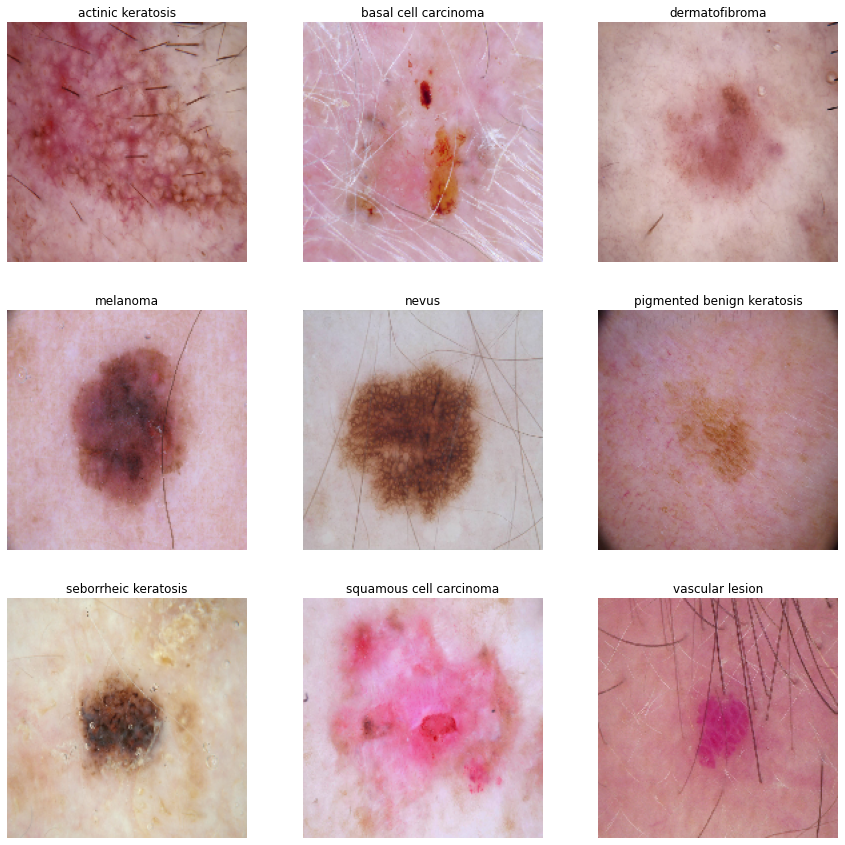

In [ ]:
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

# Model Building

In [ ]:
# train dataset 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [ ]:
# validation dataset 
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

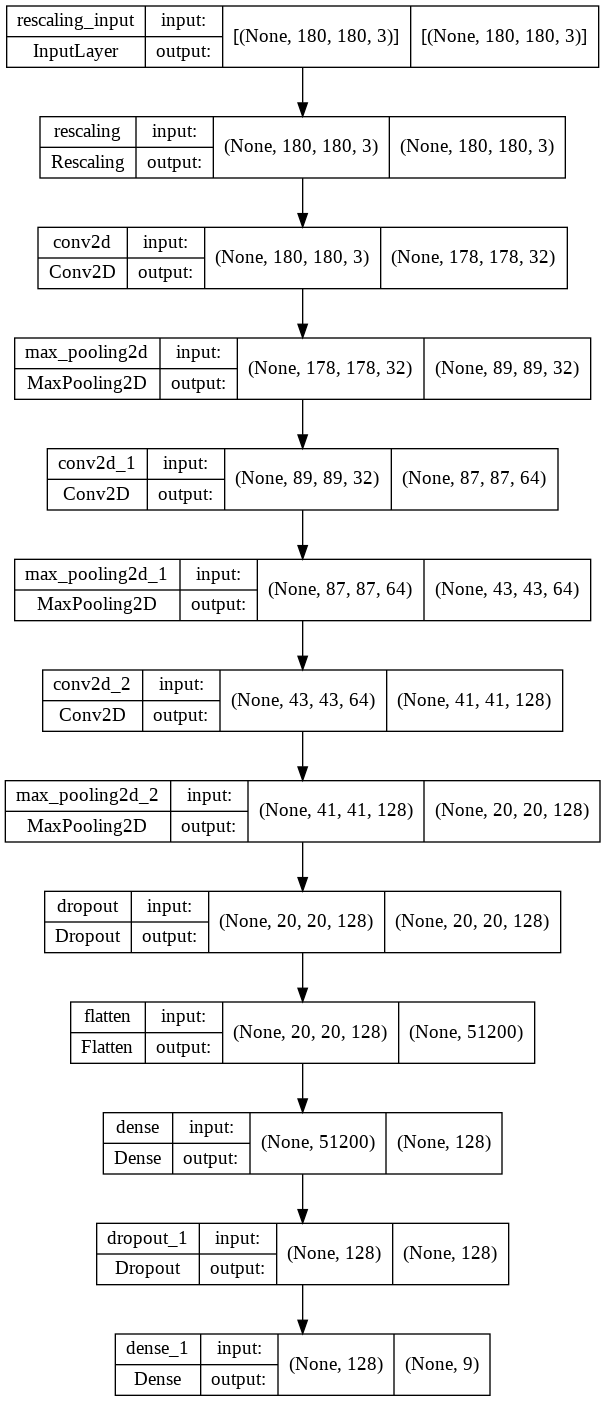

In [ ]:
# vizualizing the model 
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [ ]:
# Train the model
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/20
169/169 [==============================] - ETA: 0s - loss: 1.8300 - accuracy: 0.3147
Epoch 1: val_accuracy improved from -inf to 0.43059, saving model to model.h5
169/169 [==============================] - 603s 733ms/step - loss: 1.8300 - accuracy: 0.3147 - val_loss: 1.4989 - val_accuracy: 0.4306
Epoch 2/20
169/169 [==============================] - ETA: 0s - loss: 1.4945 - accuracy: 0.4353
Epoch 2: val_accuracy improved from 0.43059 to 0.51596, saving model to model.h5
169/169 [==============================] - 7s 40ms/step - loss: 1.4945 - accuracy: 0.4353 - val_loss: 1.2658 - val_accuracy: 0.5160
Epoch 3/20
169/169 [==============================] - ETA: 0s - loss: 1.3263 - accuracy: 0.4978
Epoch 3: val_accuracy improved from 0.51596 to 0.51670, saving model to model.h5
169/169 [==============================] - 7s 40ms/step - loss: 1.3263 - accuracy: 0.4978 - val_loss: 1.2390 - val_accuracy: 0.5167
Epoch 4/20
169/169 [==============================] - ETA: 0s - loss: 1.2

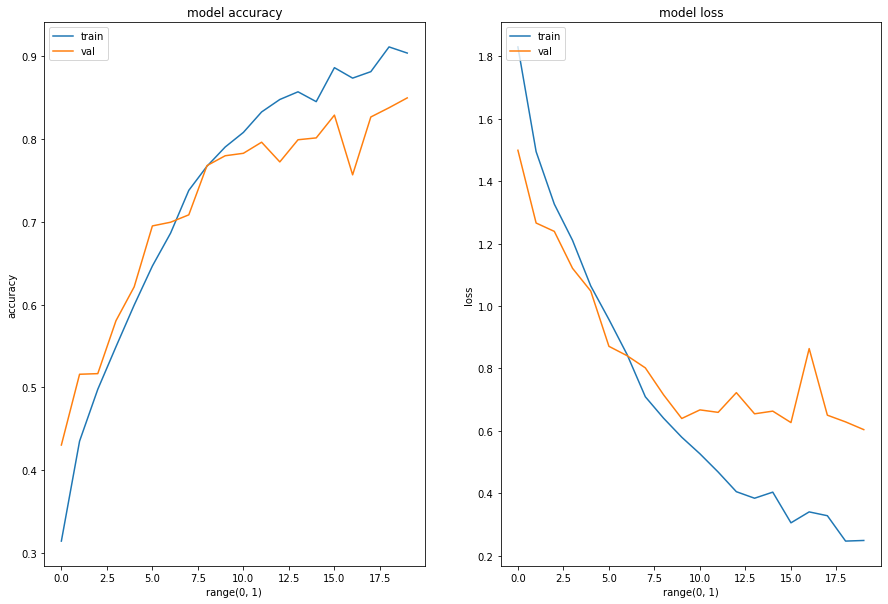

In [ ]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Model Overfit or Underfit?

In [ ]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)



43/43 [==============================] - 1s 17ms/step - loss: 0.6039 - accuracy: 0.8493
Accuracy:  0.9532641172409058
Validation Accuracy:  0.8492947220802307
Loss:  0.1266951709985733
Validation Loss 0.6038891673088074


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

image_class = ['nevus','melanoma','basal_cell_caricoma','actinic_keratosis','vasc_lesion','dermatofibroma', 'pigmented_keratosis', 'seborrheic_keratosis', 'squamous_carci']

train_batches = datagen.flow_from_directory(data_dir_train, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
 )

valid_batches = datagen.flow_from_directory(data_dir_test, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
)

Found 2390 images belonging to 9 classes.
Found 48 images belonging to 9 classes.


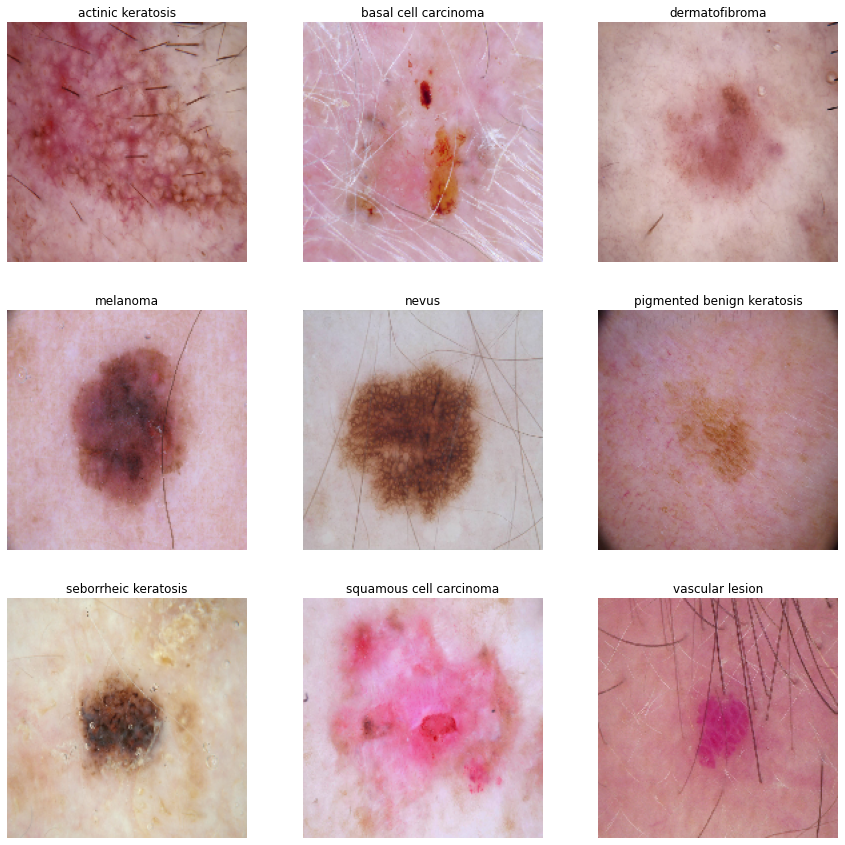

In [ ]:
# visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")


**Create the model, compile and train the model**

In [ ]:
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D

In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings


model = Sequential()

# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(180,180,3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))



# Compiling the model

In [ ]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

In order to make the optimizer converge faster and closest to the global minimum of the loss function, i used an annealing method of the learning rate (LR).

The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.

In [ ]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

# Training the model

In [ ]:
epochs = 20
batch_size = 10
history = model.fit(train_batches,
  epochs = epochs, verbose = 1, validation_data=valid_batches , callbacks=[learning_rate_reduction])

Epoch 1/20
38/38 [==============================] - 86s 2s/step - loss: 30.0385 - accuracy: 0.3569 - val_loss: 1.9967 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/20
38/38 [==============================] - 67s 2s/step - loss: 1.1887 - accuracy: 0.3632 - val_loss: 1.5969 - val_accuracy: 0.3542 - lr: 0.0010
Epoch 3/20
38/38 [==============================] - 66s 2s/step - loss: 1.1243 - accuracy: 0.3967 - val_loss: 1.7329 - val_accuracy: 0.3958 - lr: 0.0010
Epoch 4/20
38/38 [==============================] - 67s 2s/step - loss: 1.1417 - accuracy: 0.3891 - val_loss: 1.9571 - val_accuracy: 0.2917 - lr: 0.0010
Epoch 5/20
38/38 [==============================] - 65s 2s/step - loss: 0.9614 - accuracy: 0.4954 - val_loss: 1.3132 - val_accuracy: 0.5417 - lr: 0.0010
Epoch 6/20
38/38 [==============================] - 67s 2s/step - loss: 0.8612 - accuracy: 0.6013 - val_loss: 1.1727 - val_accuracy: 0.6042 - lr: 0.0010
Epoch 7/20
38/38 [==============================] - 65s 2s/step - loss: 0.8306 - 

# **Visualizing the results**

<built-in method keys of dict object at 0x7f2a8bc7efa0> :


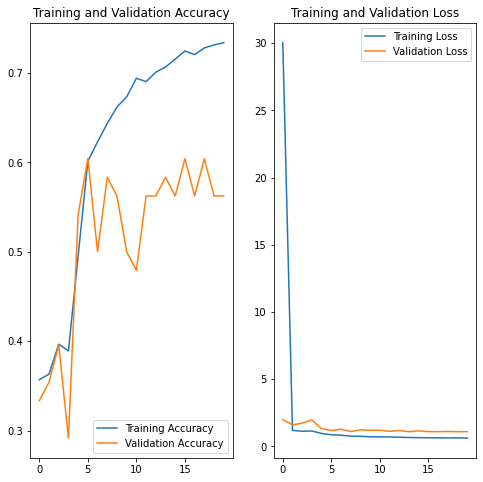

In [ ]:
acc = history.history['accuracy']
print(history.history.keys, ":")
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

43/43 [==============================] - 1s 33ms/step - loss: 5.4048 - accuracy: 0.1010
Accuracy:  0.10330118983983994
Validation Accuracy:  0.10096510499715805
Loss:  5.160046100616455
Validation Loss 5.404784202575684


Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,basal cell carcinoma,376
1,actinic keratosis,114
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


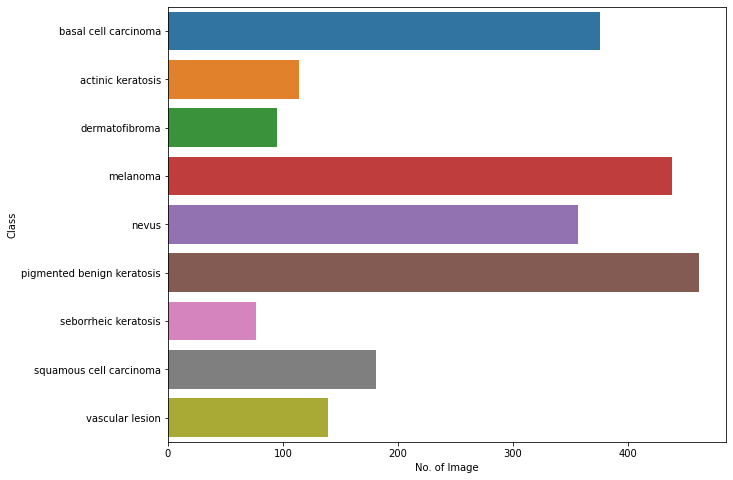

In [ ]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

There is a class imbalance to solve this using a python package Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
#install Augmentor
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
path_to_training_dataset="/content/gdrive/MyDrive/Colab Notebooks/Karen/CNN_assignment.zip (Unzipped Files)/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"


In [ ]:
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Karen/CNN_assignment.zip (Unzipped Files)/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F2B1069FA90>: 100%|██████████| 500/500 [00:20<00:00, 24.30 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Karen/CNN_assignment.zip (Unzipped Files)/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F2B1FE6CA50>: 100%|██████████| 500/500 [00:18<00:00, 27.13 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Karen/CNN_assignment.zip (Unzipped Files)/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2B97055BD0>: 100%|██████████| 500/500 [00:19<00:00, 26.02 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Karen/CNN_assignment.zip (Unzipped Files)/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F2B1FEC1DD0>: 100%|██████████| 500/500 [01:35<00:00,  5.24 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Karen/CNN_assignment.zip (Unzipped Files)/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7F2A8B8315D0>: 100%|██████████| 500/500 [01:27<00:00,  5.73 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Karen/CNN_assignment.zip (Unzipped Files)/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2A8BE2AC90>: 100%|██████████| 500/500 [00:19<00:00, 25.91 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Karen/CNN_assignment.zip (Unzipped Files)/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F2B204F4710>: 100%|██████████| 500/500 [00:44<00:00, 11.27 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Karen/CNN_assignment.zip (Unzipped Files)/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2B1FE6CA50>: 100%|██████████| 500/500 [00:18<00:00, 26.41 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Karen/CNN_assignment.zip (Unzipped Files)/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2B204EF090>: 100%|██████████| 500/500 [00:19<00:00, 25.88 Samples/s]


In [ ]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


Lets see the distribution of augmented data after adding new images to the original training data.

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

# Train the model on the data created using Augmentor


In [ ]:
batch_size = 32
img_height = 180
img_width = 180

# Create a training dataset

In [ ]:
data_dir_train="/content/gdrive/MyDrive/Colab Notebooks/Karen/CNN_assignment.zip (Unzipped Files)/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


# Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [ ]:
from tensorflow.keras.layers import BatchNormalization

# Create your model (make sure to include normalization)

In [ ]:
model = Sequential()

# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(180,180,3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))

# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='softmax'))



# Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

Train your model

In [ ]:
epochs = 20

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

batch_size = 10
history = model.fit(train_ds,
  epochs = epochs, verbose = 1, validation_data=val_ds , callbacks=[learning_rate_reduction])

Epoch 1/20
281/281 [==============================] - 54s 187ms/step - loss: 0.0000e+00 - accuracy: 0.1208 - val_loss: 0.0000e+00 - val_accuracy: 0.1291 - lr: 0.0010
Epoch 2/20
281/281 [==============================] - 52s 183ms/step - loss: 0.0000e+00 - accuracy: 0.1208 - val_loss: 0.0000e+00 - val_accuracy: 0.1291 - lr: 0.0010
Epoch 3/20
281/281 [==============================] - 51s 179ms/step - loss: 0.0000e+00 - accuracy: 0.1208 - val_loss: 0.0000e+00 - val_accuracy: 0.1291 - lr: 0.0010
Epoch 4/20
281/281 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.1208
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
281/281 [==============================] - 52s 183ms/step - loss: 0.0000e+00 - accuracy: 0.1208 - val_loss: 0.0000e+00 - val_accuracy: 0.1291 - lr: 0.0010
Epoch 5/20
281/281 [==============================] - 51s 180ms/step - loss: 0.0000e+00 - accuracy: 0.1208 - val_loss: 0.0000e+00 - val_accuracy: 0.1291 - lr: 5.0000e-04
E

# Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Model Prediction**

Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


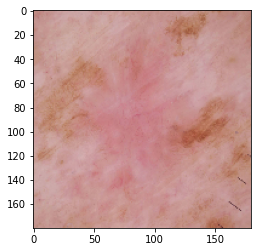

In [ ]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[2],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )

# Did you get rid of underfitting/overfitting? Did class rebalance help?

The class rebalance helped in reducing overfitting of the data and thus the loss is reduced resulting in lower accuracy

Initially we tried without the ImageDataGenerator which created data to over fit at high ratio. Then we introduced dropout and ImageDataGenerator which reduced the over fit

At last we tried Batch Normalization and Augumentation which really helped in to reduce overfit